In [ ]:
#!pip install accelerate -U

In [ ]:
import transformers
import torch, torchtext
import torch.nn.functional as F
import torch.nn as nn
import copy

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AutoModel, AutoProcessor
from tqdm import tqdm

import os
import math
import gc
import datetime

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

from torchvision import transforms
from torchvision.utils import make_grid
import torch.optim as optim
import itertools
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = 4
num_epochs = 25
image_size = 224

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

MODEL_NUM_LABELS = 2
EMBEDDING_DIM = 768
TEXT_MODEL_CARD = 'bert-base-uncased'
AUDIO_MODEL_CARD = 'facebook/wav2vec2-base-960h'

LABEL_2_ID = {
    'normal': 0,
    'Lung': 1
}

ID_2_LABEL = {
    0: 'normal',
    1: 'Lung'
}

num_processors = os.cpu_count()

cpu
Using device: cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class PositionalEncoding(nn.Module):
    """
        Positional Encoding for Transformer
    """
    def __init__(self, d_model: int, dual_modality=False, dropout: float = 0.1, max_len: int = 5000):
        """
        Args:
            d_model: dimension of model
            dual_modality: when True, add a sequence of 0s or 1s depending on the modality
            dropout: dropout rate
            max_len: max length of sequence
        """
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        self.dual_modality = dual_modality
        self.pe = self.pe.to(device)

    def forward(self, x, is_first=True):
        """
        Args:
            x: input tensor (bs, sqlen, emb)
            is_first: True if the first modality, False if the second modality
        """
        if self.dual_modality:
            modality = torch.ones((x.shape[0], x.shape[1], 4), dtype=torch.float32).to(device) * (0 if is_first else 1)
            x = x + self.pe[:, :x.size(1)]
            x = self.dropout(x)
            return torch.cat((x, modality), axis=-1)
        else:
            # x = (bs, sqlen, emb)  pe = (1, sqlen, emb)
            x = x + self.pe[:, :x.size(1)]
            return self.dropout(x)



class CustomScaleDotProductAttention(nn.Module):
    """
    compute scale dot product attention

    Query : given sentence that we focused on (decoder)
    Key : every sentence to check relationship with Qeury(encoder)
    Value : every sentence same with Key (encoder)
    """

    def __init__(self):
        super(CustomScaleDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, text_mask, audio_mask, e=1e-12):
        """
        Args:
            q: query (decoder)
            k: key (encoder)
            v: value (encoder)
            text_mask: mask for text sequence
            audio_mask: mask for audio sequence
            e: epsilon value for masking
        """
        # input is 4 dimension tensor
        # [batch_size, head, length, d_tensor]
        batch_size, head, length, d_tensor = k.size()

        # 1. dot product Query with Key^T to compute similarity
        k_t = k.transpose(2, 3)  # transpose
        score = (q @ k_t) / math.sqrt(d_tensor)  # scaled dot product
        ## score dimension: (batch, n_heads, length, length)

        # 2. apply masking (opt)
        padding_mask = torch.cat((text_mask, audio_mask), dim=1).unsqueeze(1)
        ## padding_mask is now (batch, 1, seq_length)
        score = score.masked_fill(padding_mask.unsqueeze(-1) == 0, -10_000) # padding_mask applied = (batch, 1, seq_length, 1)
        score = score.masked_fill(padding_mask.unsqueeze(1) == 0, -10_000) # padding_mask applied = (batch, 1, 1, seq_length)

        # 3. pass them softmax to make [0, 1] range
        score = self.softmax(score)

        # 4. multipy score with attention coefficients
        text_lengths = torch.sum(text_mask, dim=1)
        audio_lengths = torch.sum(audio_mask, dim=1)
        ## text_length and audio_length dimension = (batch,)

        total_lengths = text_lengths + audio_lengths
        ## total_lengths dimension = (batch,)

        text_coefficients = (total_lengths / (2*text_lengths)).unsqueeze(-1)
        audio_coefficients = (total_lengths / (2*audio_lengths)).unsqueeze(-1)
        ## text_coefficients and audio_coefficients dimension = (batch, 1)

        text_weights = text_mask*text_coefficients
        audio_weights = audio_mask*audio_coefficients
        ## text_weights dimension = (batch, text_sequence_length)
        ## audio_weights dimension = (batch, audio_sequence_length)

        attention_coefficients = torch.cat((text_weights, audio_weights), dim=1).unsqueeze(1).unsqueeze(1)
        ## attention_coefficients dimension = (batch, 1, 1, total_sequence_length)
        score = score * attention_coefficients

        # 5. multiply with Value
        v = score @ v

        return v, score


class CustomMultiHeadAttention(nn.Module):
    """
    Multi Head Attention Class for Transformer
    """
    def __init__(self, d_model, n_head):
        """
        Args:
            d_model: dimension of model
            n_head: number of heads
        """
        super(CustomMultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.attention = CustomScaleDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, text_mask, audio_mask):
        """
        Args:
            q: query (decoder)
            k: key (encoder)
            v: value (encoder)
            text_mask: mask for text sequence
            audio_mask: mask for audio sequence
        """
        # 1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. split tensor by number of heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # 3. do scale dot product to compute similarity
        out, attention = self.attention(q, k, v, text_mask, audio_mask)

        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        # 5. visualize attention map
        # TODO : we should implement visualization

        return out

    def split(self, tensor):
        """
        split tensor by number of head

        Args:
            tensor: [batch_size, length, d_model]
        """

        batch_size, length, d_model = tensor.size()

        d_tensor = d_model // self.n_head
        tensor = tensor.view(batch_size, length, self.n_head, d_tensor).transpose(1, 2)
        # it is similar with group convolution (split by number of heads)

        return tensor

    def concat(self, tensor):
        """
        inverse function of self.split(tensor : torch.Tensor)
        Args:
            tensor: [batch_size, head, length, d_tensor]
        """
        batch_size, head, length, d_tensor = tensor.size()
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, length, d_model)
        return tensor

class LayerNorm(nn.Module):
    """
    Layer Normalization Class
    """
    def __init__(self, d_model, eps=1e-12):
        """
        Args:
            d_model: dimension of model
            eps: epsilon value for masking
        """
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        """
        Args:
            x: input tensor
        """
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)
        # '-1' means last dimension.

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out

class PositionwiseFeedForward(nn.Module):
    """
    Position-wise Feed Forward Layer
    """
    def __init__(self, d_model, hidden, drop_prob=0.1):
        """
        Args:
            d_model: dimension of model
            hidden: dimension of hidden layer
            drop_prob: dropout rate
        """
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        """
        Args:
            x: input tensor
        """
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

class CustomEncoderLayer(nn.Module):
    """
    Encoder Layer Class
    """
    def __init__(self, d_model, ffn_hidden, n_head, drop_prob):
        """
        Args:
            d_model: dimension of model
            ffn_hidden: dimension of hidden layer
            n_head: number of heads
            drop_prob: dropout rate
        """
        #https://medium.com/@hunter-j-phillips/position-wise-feed-forward-network-ffn-d4cc9e997b4c

        super(CustomEncoderLayer, self).__init__()
        self.attention = CustomMultiHeadAttention(d_model=d_model, n_head=n_head)
        self.norm1 = LayerNorm(d_model=d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNorm(d_model=d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, text_mask, audio_mask):
        """
        Args:
            x: input tensor
            text_mask: mask for text sequence
            audio_mask: mask for audio sequence
        """
        # 1. compute self attention
        _x = x
        x = self.attention(q=x, k=x, v=x, text_mask=text_mask, audio_mask=audio_mask)

        # 2. add and norm
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        # 3. positionwise feed forward network
        _x = x
        x = self.ffn(x)

        # 4. add and norm
        x = self.dropout2(x)
        x = self.norm2(x + _x)
        return x

class CustomEncoder(nn.Module):
    """
    Encoder Class
    """
    def __init__(self, d_model, ffn_hidden, n_head, n_layers, drop_prob):
        """
        Args:
            d_model: dimension of model
            ffn_hidden: dimension of hidden layer
            n_head: number of heads
            n_layers: number of layers
            drop_prob: dropout rate
        """
        super().__init__()

        self.layers = nn.ModuleList([CustomEncoderLayer(d_model=d_model,ffn_hidden=ffn_hidden,n_head=n_head,drop_prob=drop_prob) for _ in range(n_layers)])

    def forward(self, embedding, text_mask, audio_mask):
        """
        Args:
            embedding: input tensor
            text_mask: mask for text sequence
            audio_mask: mask for audio sequence
        """
        x = embedding
        for layer in self.layers:
            x = layer(x, text_mask, audio_mask)

        return x

In [ ]:
import os
path = "/content/drive/MyDrive/LungsImgDatasetInd/images_normalized"
dir_list = os.listdir(path)

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/LungsImgDatasetInd/indiana_projections.csv')
df1 = pd.read_csv('/content/drive/MyDrive/LungsImgDatasetInd/indiana_reports.csv')
df2 = df2.loc[df2['projection'].isin(['Frontal'])]
df2 = df2.loc[df2['filename'].isin(dir_list)]
df1.loc[df1['Problems'].str.contains('Lung'),'Problems']='Lung'
df1_l = df1.loc[df1['Problems'].isin(['Lung'])]

df1_n = df1.loc[df1['Problems'].isin(['normal'])]
print(len(df1_l), len(df1_n))
df1_n = df1_n.iloc[:len(df1_l)-len(df1_n)]
df1 = pd.concat([df1_l, df1_n], axis=0).sample(frac=1).reset_index(drop=True)
df1 = df1[:]
print(len(df1))


images_captions_df = pd.DataFrame({'image': [],
                                    'caption': [],'number_of_words':[],'problem':[]})
for i in range(len(df2)):
    uid = df2.iloc[i]['uid']
    image = df2.iloc[i]['filename']
    index = df1.loc[df1['uid'] ==uid]

    if not index.empty:
        index = index.index[0]
        caption = df1.loc[index]['findings']
        problem = df1.loc[index]['Problems']
        number_of_words = len(str(caption).split())

        if type(caption) == float:
                continue
        images_captions_df = pd.concat([images_captions_df, pd.DataFrame([{'image': image, 'caption': caption ,'number_of_words':number_of_words,'problem':problem}])], ignore_index=True)

images_captions_df["number_of_words"] =  images_captions_df["caption"].apply(lambda text: len(str(text).split()))
images_captions_df['number_of_words'] = images_captions_df['number_of_words'].astype(int)

print(images_captions_df.head())


from sklearn.model_selection import train_test_split

image_folder = '/content/drive/MyDrive/LungsImgDatasetInd/images_normalized'
image_filenames = images_captions_df.image.values

train_captions,test_val_captions =train_test_split(images_captions_df, test_size = 0.2)
test_captions, val_captions =train_test_split(test_val_captions, test_size = 0.4)

print(train_captions.head())
print(len(train_captions),len(test_captions),len(val_captions))

558 1379
1116
                       image  \
0     1_IM-0001-4001.dcm.png   
1  5_IM-2117-1003002.dcm.png   
2    11_IM-0067-1001.dcm.png   
3    12_IM-0133-1001.dcm.png   
4    14_IM-0256-1001.dcm.png   

                                             caption  number_of_words problem  
0  The cardiac silhouette and mediastinum size ar...               34  normal  
1  The cardiomediastinal silhouette and pulmonary...               42    Lung  
2  Cardiomediastinal silhouette and pulmonary vas...               21  normal  
3  Lungs are clear bilaterally. Cardiac and media...               23  normal  
4  Heart size within normal limits, stable medias...               37    Lung  
                         image  \
93    238_IM-0939-1001.dcm.png   
886  3347_IM-1605-4004.dcm.png   
290   708_IM-2271-1001.dcm.png   
134   318_IM-1500-1001.dcm.png   
96    244_IM-0978-1001.dcm.png   

                                               caption  number_of_words  \
93   Stable cardiomediastinal sil

(224, 224, 3)


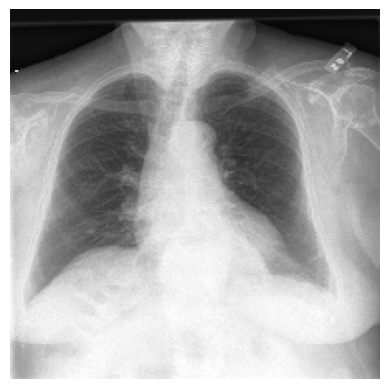

In [ ]:
def image_preprocessing(image_path,target_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img,(target_size,target_size), )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def display_image(image_array):
    plt.imshow(image_array)
    plt.axis('off')
    plt.show()

image = image_preprocessing("/content/drive/MyDrive/LungsImgDatasetInd/images_normalized/1003_IM-0005-2002.dcm.png",image_size)
print(image.shape)
display_image(image)

In [ ]:
# Example dataset class
class ImageTextDataset(Dataset):
    def __init__(self, image_filenames, captions, problems, image_size=256):
        self.image_filenames = image_filenames
        self.captions = captions
        self.problems = problems
        self.transform = transforms.Compose([
                                                 # Resize images to a consistent size
                                                #transforms.ToTensor(),
                                                transforms.ToTensor(),          # Convert images to tensors
                                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
                                            ])
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image_path = "/content/drive/MyDrive/LungsImgDatasetInd/images_normalized/"+image_filenames[index]

        image = image_preprocessing(image_path,image_size ) #
        image = list(np.array(self.transform(image)))#.permute(2,1,0)
        text = self.captions[index]
        problem = LABEL_2_ID[self.problems[index]]

        return image, text, problem

# Create an instance of the dataset

train_dataset = ImageTextDataset(train_captions.image.values, train_captions.caption.values, train_captions.problem.values, image_size)
test_dataset = ImageTextDataset(test_captions.image.values, test_captions.caption.values, test_captions.problem.values, image_size)
val_dataset = ImageTextDataset(val_captions.image.values, val_captions.caption.values, val_captions.problem.values, image_size)
print('train_dataset: ',len(train_dataset),'test_dataset: ',len(test_dataset),'val_dataset: ',len(val_dataset))

train_dataset:  777 test_dataset:  117 val_dataset:  78


In [ ]:
val_captions.problem.values

array(['Lung', 'Lung', 'Lung', 'normal', 'Lung', 'Lung', 'normal', 'Lung',
       'Lung', 'Lung', 'normal', 'Lung', 'normal', 'normal', 'normal',
       'Lung', 'normal', 'Lung', 'Lung', 'Lung', 'normal', 'normal',
       'normal', 'Lung', 'normal', 'Lung', 'normal', 'normal', 'normal',
       'normal', 'Lung', 'normal', 'normal', 'Lung', 'Lung', 'Lung',
       'Lung', 'Lung', 'normal', 'Lung', 'normal', 'Lung', 'Lung',
       'normal', 'Lung', 'Lung', 'normal', 'normal', 'normal', 'normal',
       'Lung', 'Lung', 'normal', 'normal', 'Lung', 'normal', 'Lung',
       'normal', 'Lung', 'normal', 'normal', 'Lung', 'Lung', 'Lung',
       'Lung', 'normal', 'Lung', 'normal', 'Lung', 'Lung', 'Lung', 'Lung',
       'normal', 'normal', 'Lung', 'normal', 'normal', 'normal'],
      dtype=object)

# # Create a DataLoader

In [ ]:
def create_dataloader(dataset, batch_size):
    """
    Create a DataLoader object from the given dataset with the given batch size
    Args:
        dataset: dataset to use
        batch_size: batch size to use
    """
    def pack_fn(batch):
        """
        Function to pad the audio features and create the attention mask
        """
        texts = [x[1] for x in batch]
        ''''for x in batch:
            print(type(x[0]),x[0].shape)
            print('x[0]\r\n',x[0])'''
        img_features = [x[0] for x in batch]
        img_features = np.array(img_features)
        audio_features= torch.from_numpy(img_features)
        labels = torch.tensor([x[2] for x in batch])
        return texts, audio_features, labels

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pack_fn)
    return dataloader

In [ ]:
train_dataloader = create_dataloader(train_dataset, batch_size)
val_dataloader = create_dataloader(val_dataset, batch_size)
test_dataloader = create_dataloader(test_dataset, batch_size)

In [ ]:
def create_models(
        head_hidden_dimension=224, dropout_prob=0.1, hidden_state_index=8,   # shared parameters head_hidden_dimension=256
        audioonly_nheads=8, audioonly_d_ffn=100, audioonly_n_layers=1, # audio only parameters
        csa_nheads=4, csa_d_ffn=2048, csa_n_layers=1, # multimodal parameters
        ensembling_nheads=4, ensembling_d_ffn=2048, ensembling_n_layers=1, # ensembling parameters
        multa_nblocks=4, multa_d_ffn=2048 # unaligned parameters
    ):
    text_only_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    text_only = TextModel(tokenizer, embedder, text_only_head)
    model_names = ['Text-Only']
    models = [text_only]
    return model_names, models

In [ ]:
# set up tokenizer and model
tokenizer = BertTokenizer.from_pretrained(TEXT_MODEL_CARD)
embedder = BertModel.from_pretrained(TEXT_MODEL_CARD).to(device)

# freeze bert layers
for params in embedder.parameters():
    params.requires_grad = False

num_claim = len(df1.loc[df1['Problems'].isin(['normal'])])
print(f'Total Normal: {num_claim}: {num_claim*100/len(df1):.2f}%')

num_premise = len(df1.loc[df1['Problems'].isin(['Lung'])])
print(f'Total Lung: {num_premise}: {num_premise*100/len(df1):.2f}%')

if MODEL_NUM_LABELS == 2:
    claim_ratio = num_claim / (num_claim + num_premise)
    premise_ratio = num_premise / (num_claim + num_premise)
    weight = torch.tensor([1/(2*claim_ratio), 1/(2*premise_ratio)]).to(device)
else:
    claim_ratio = num_claim / (num_claim + num_premise + num_other)
    premise_ratio = num_premise / (num_claim + num_premise + num_other)
    other_ratio = num_other / (num_claim + num_premise + num_other)
    weight = torch.tensor([1/(3*claim_ratio), 1/(3*premise_ratio), 1/(3*other_ratio)]).to(device)

print(f'Weight for loss function: {weight}')

Total Normal: 558: 50.00%
Total Lung: 558: 50.00%
Weight for loss function: tensor([1., 1.])


In [ ]:
class BestModel:
    """
    Class to keep track of the best performing model on validation set during training
    """
    def __init__(self):
        self.best_validation_loss = float('Infinity')
        self.best_state_dict = None
    def __call__(self, model, loss):
        if loss < self.best_validation_loss:
            self.best_validation_loss = loss
            self.best_state_dict = copy.deepcopy(model.state_dict())

def evaluate(model, data_loader, loss_fn, debug=False):
    """
    Evaluate the model on the set passed
    Args:
        model: model to evaluate
        data_loader: DataLoader object
        loss_fn: loss function to use
        debug: whether to print debug statements
    """
    model.eval()
    total_loss = 0.0
    num_correct = 0
    num_examples = 0
    tot_pred, tot_targ, tot_logits = torch.LongTensor(), torch.LongTensor(), torch.LongTensor()
    for batch in data_loader:
        texts, img_features, targets = batch
        output = model(texts,img_features)
        loss = loss_fn(output, targets)
        total_loss += loss.detach()

        scores = output[:, :2]
        predicted_labels = torch.argmax(scores, dim=-1)

        tot_pred = torch.cat((tot_pred, predicted_labels.detach().cpu()))
        tot_targ = torch.cat((tot_targ, targets.detach().cpu()))
        tot_logits = torch.cat((tot_logits, torch.nn.functional.softmax(scores, dim=-1)[:, 1].detach().cpu()))

        correct = torch.eq(predicted_labels, targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    total_loss = total_loss.cpu().item()
    total_loss /= len(data_loader.dataset)
    accuracy = num_correct/num_examples
    return total_loss, accuracy, tot_pred, tot_targ, tot_logits


def train(model, loss_fn, train_loader, val_loader, epochs=10, device="cuda", lr=1e-3, lr_decay_factor=0.1, lr_decay_patience=3, weight_decay=1e-5, verbose=True, debug=False):
    """
    Train the model on the train set and evaluate on the validation set with the given parameters
    Args:
        model: model to train
        loss_fn: loss function to use
        train_loader: DataLoader object for train set
        val_loader: DataLoader object for validation set
        epochs: number of epochs
        device: device to use
        lr: initial learning rate
        lr_decay_factor: factor to decay learning rate
        lr_decay_patience: patience for learning rate decay
        weight_decay: weight decay
        verbose: whether to print training results
        debug: whether to print debug statements
    """
    # set up optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=lr_decay_patience, verbose=True)
    best_model_tracker = BestModel()
    # history of train and validation losses, accuracy
    history_train_losses = []
    history_train_accuracy = []

    history_val_losses = []
    history_val_accuracy = []

    for epoch in tqdm(range(epochs)):
        # training
        correct = 0
        training_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            texts, img_features, targets = batch
            output = model(texts,img_features)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            correct += torch.eq(torch.argmax(output, dim=-1), targets).view(-1).sum()
            training_loss += loss.detach()
        training_loss = training_loss.cpu().item()

        training_loss /= len(train_loader.dataset)
        training_accuracy = correct.item() / len(train_loader.dataset)

        valid_loss, valid_accuracy, val_pred, val_targ, _ = evaluate(model, val_loader, loss_fn, debug)
        print(val_pred, val_targ)

        history_train_losses.append(training_loss)
        history_train_accuracy.append(training_accuracy)

        history_val_losses.append(valid_loss)
        history_val_accuracy.append(valid_accuracy)

        print(valid_loss, best_model_tracker.best_validation_loss)
        if valid_loss < best_model_tracker.best_validation_loss:
          print('save model')
          torch.save(model, '/content/drive/MyDrive/models/'+'text_model_'+datetime.datetime.now().strftime("%Y_%m_%d_%H_%M"))

        best_model_tracker(model, valid_loss)
        scheduler.step(valid_loss)

        if verbose:
            print(f'Epoch: {epoch}, Training Loss: {training_loss:.4f}, Validation Loss: {valid_loss:.4f}, accuracy = {valid_accuracy:.4f}')
    # restore best model weights
    model.load_state_dict(best_model_tracker.best_state_dict)

    history = {
        'train_loss': history_train_losses,
        'train_accuracy': history_train_accuracy,
        'train_f1': history_train_f1,
        'val_loss': history_val_losses,
        'val_accuracy': history_val_accuracy
    }
    return model, history

In [ ]:
class TextModel(nn.Module):
    """
    Class for the text-only model
    """
    def __init__(self, tokenizer, embedder, head):
        """
        Args:
            tokenizer: tokenizer to use
            embedder: embedder to use
            head: head to use
        """
        super().__init__()
        self.tokenizer = tokenizer
        self.embedder = embedder
        self.head = head
    def forward(self, texts, audio_features):
        """, audio_attention
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        """
        вернуть  torch.Tensor return_tensors='pt'
        padding=True - Дополнить до самой длинной последовательности в пакете
        """
        tokenizer_output = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=False).to(device)
        embedder_output = self.embedder(**tokenizer_output, output_hidden_states=True)
        text_features = embedder_output['last_hidden_state']
        text_features_sum = (text_features * tokenizer_output.attention_mask.unsqueeze(-1)).sum(axis=1) #torch.Size([4, 768])
        text_features_pooled = text_features_sum / tokenizer_output.attention_mask.sum(axis=1).unsqueeze(-1) #torch.Size([4, 768])
        return self.head(text_features_pooled)

In [ ]:
#SEEDS = [1, 42, 69, 100, 420]
SEEDS = [1]
from transformers import TrainingArguments
dict_model_names = ['Text-Only']

# initialize results
val_results = {n : [] for n in dict_model_names}
test_results = {n : [] for n in dict_model_names}

# initialize history
history_train_losses = {n : [] for n in dict_model_names}
history_train_accuracy = {n : [] for n in dict_model_names}
history_train_f1 = {n : [] for n in dict_model_names}
history_val_losses = {n : [] for n in dict_model_names}
history_val_accuracy = {n : [] for n in dict_model_names}
history_val_f1 = {n : [] for n in dict_model_names}

EPOCHS = 5
INITIAL_LR = 5e-5
WEIGHT_DECAY = 0.01
LR_DECAY_FACTOR = 0.9
LR_DECAY_PATIENCE = 15
VERBOSE_TRAIN = True
DEBUG_TRAIN = False

for seed in SEEDS:
    print(f'{f"TRAINING WITH SEED {seed}":=^100}')
    print()
    torch.manual_seed(seed)
    np.random.seed(seed)
    model_names, models = create_models()
    while models:
        model = models[0]
        model_name = model_names[0]

        torch.manual_seed(seed)
        np.random.seed(seed)

        print(f'{f"Training model {model_name}":_^100}')

        loss = nn.CrossEntropyLoss(weight=weight)

        _, history = train(
              model,
              loss,
              epochs=EPOCHS,
              train_loader=train_dataloader,
              val_loader=val_dataloader,
              device=device,
              weight_decay=WEIGHT_DECAY,
              lr=INITIAL_LR,
              )
        history_train_losses[model_name].append(history['train_loss'])
        history_train_accuracy[model_name].append(history['train_accuracy'])
        history_val_losses[model_name].append(history['val_loss'])
        history_val_accuracy[model_name].append(history['val_accuracy'])

        _, val_acc, val_pred, val_targ, val_logits = evaluate(model, val_dataloader, loss)
        print(val_pred, val_targ)
        val_results[model_name].append({'acc': val_acc, 'pred': val_pred, 'targ': val_targ, 'logits':val_logits})

        _, test_acc, test_pred, test_targ, test_logits = evaluate(model, test_dataloader, loss)
        test_results[model_name].append({'acc': test_acc, 'pred': test_pred, 'targ': test_targ, 'logits':test_logits})
        print(test_pred, test_targ)
        if VERBOSE_TRAIN:
            print(f'[VAL] Model: {model_name} - acc: {val_acc:.4f}')
            print(f'[TEST] Model: {model_name} - acc: {test_acc:.4f}')
            print()

        # delete model to free up memory and avoid memory errors
        del model
        del models[0]
        del model_names[0]
        gc.collect()

========================================TRAINING WITH SEED 1========================================

______________________________________Training model Text-Only______________________________________


  0%|          | 0/10 [00:00<?, ?it/s]

tensor([1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 0]) tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0])
0.15366161786592925 inf
save model


 10%|█         | 1/10 [14:59<2:14:51, 899.06s/it]

Epoch: 0, Training Loss: 0.1663, Validation Loss: 0.1537, accuracy = 0.7949
tensor([0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 1]) tensor([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 1])
0.13391981369409806 0.15366161786592925
save model


 20%|██        | 2/10 [19:44<1:11:45, 538.13s/it]

Epoch: 1, Training Loss: 0.1475, Validation Loss: 0.1339, accuracy = 0.7821
tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 0]) tensor([1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 0])
0.11678113692846054 0.13391981369409806
save model


 30%|███       | 3/10 [24:37<49:43, 426.25s/it]  

Epoch: 2, Training Loss: 0.1286, Validation Loss: 0.1168, accuracy = 0.7949
tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0]) tensor([0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 0])
0.1037445801955003 0.11678113692846054
save model


 40%|████      | 4/10 [29:22<37:02, 370.47s/it]

Epoch: 3, Training Loss: 0.1149, Validation Loss: 0.1037, accuracy = 0.8462
tensor([1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0]) tensor([1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0])
0.09478940719213241 0.1037445801955003
save model


 50%|█████     | 5/10 [34:11<28:25, 341.15s/it]

Epoch: 4, Training Loss: 0.1037, Validation Loss: 0.0948, accuracy = 0.8846
tensor([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 0]) tensor([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0])
0.09013408880967361 0.09478940719213241
save model


 60%|██████    | 6/10 [38:51<21:21, 320.29s/it]

Epoch: 5, Training Loss: 0.0934, Validation Loss: 0.0901, accuracy = 0.8590
tensor([0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 1]) tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 1])
0.08186669227404472 0.09013408880967361
save model


 70%|███████   | 7/10 [43:44<15:33, 311.28s/it]

Epoch: 6, Training Loss: 0.0842, Validation Loss: 0.0819, accuracy = 0.8846
tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1]) tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 1])
0.08086109161376953 0.08186669227404472
save model


 80%|████████  | 8/10 [48:29<10:06, 303.02s/it]

Epoch: 7, Training Loss: 0.0815, Validation Loss: 0.0809, accuracy = 0.8974
tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 0]) tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 0])
0.07363203855661246 0.08086109161376953
save model


 90%|█████████ | 9/10 [53:21<04:59, 299.64s/it]

Epoch: 8, Training Loss: 0.0754, Validation Loss: 0.0736, accuracy = 0.8846


100%|██████████| 10/10 [58:01<00:00, 348.14s/it]

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 1]) tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 0])
0.08133514110858624 0.07363203855661246
Epoch: 9, Training Loss: 0.0697, Validation Loss: 0.0813, accuracy = 0.8974


tensor([1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 0]) tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]) tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 

  0%|          | 0/10 [03:50<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#model = torch.load('/content/drive/MyDrive/models/Text-Only_13_04')

In [ ]:
history_train_losses = []
history_train_accuracy = []
history_train_f1 = []
history_val_losses = []
history_val_accuracy = []
history_val_f1 = []

history_train_losses.append(history['train_loss'])
history_train_accuracy.append(history['train_accuracy'])
history_val_losses.append(history['val_loss'])
history_val_accuracy.append(history['val_accuracy'])

_, val_acc, val_pred, val_targ, val_logits = evaluate(model, val_dataloader, loss)
print(val_pred, val_targ)

_, test_acc, test_pred, test_targ, test_logits = evaluate(model, test_dataloader, loss)
print(test_pred, test_targ)
if VERBOSE_TRAIN:
    print(f'[VAL] Model: {model_name} - acc: {val_acc:.4f}')
    print(f'[TEST] Model: {model_name} - acc: {test_acc:.4f}')
    print()

tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 1]) tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0])
tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]) tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 

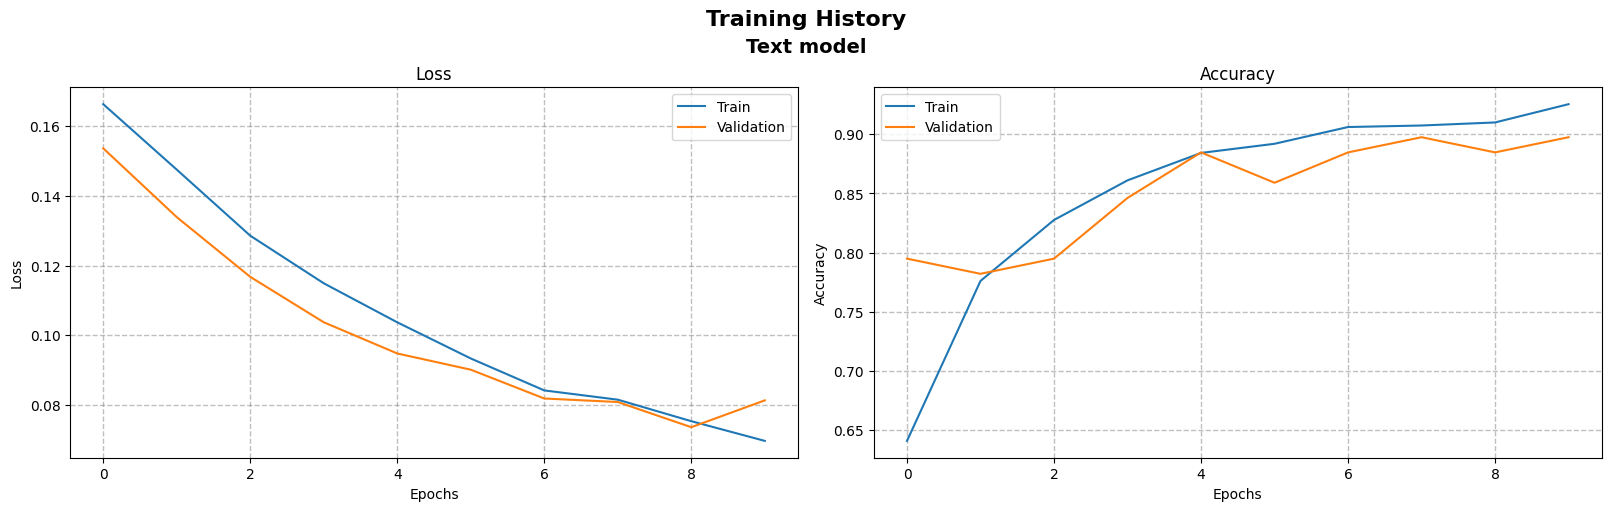

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(16, 5))
fig.suptitle('Training History', fontsize=16, fontweight='bold')

subfig = fig.subfigures(nrows=1, ncols=1)
subfig.suptitle(f'Text model', fontsize=14, fontweight='bold')
axs = subfig.subplots(nrows=1, ncols=2)
for col, ax in enumerate(axs):
    if col == 0:
        ax.grid(color='gray', linestyle='--', linewidth=1, alpha = 0.5)
        ax.plot(history_train_losses[0], label='Train')
        ax.plot(history_val_losses[0], label='Validation')
        ax.set_title('Loss')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()

    elif col == 1:
        ax.plot(history_train_accuracy[0], label='Train')
        ax.plot(history_val_accuracy[0], label='Validation')
        ax.set_title('Accuracy')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.legend()
        ax.grid(color='gray', linestyle='--', linewidth=1, alpha = 0.5)
